In [1]:
# Import all of the basic libraries (you will always need these)
%matplotlib inline
from matplotlib import pyplot as pl
import numpy as np

# Import a library that contains soil moisture properties and functions
import vanGenuchten as vg

# Import ODE solvers
from scipy.interpolate import interp1d
from scipy.integrate import odeint

# Select which soil properties to use
p=vg.HygieneSandstone()

In [9]:

def RichardsModel(psi,t,dz,n,p,vg,qTop,qBot,psiTop,psiBot):
    
    """
    Richards Equation solver.
    
    Arguments:
    - psi : array-like, pressure head at each node.
    - t : time array.
    - dz : grid spacing (vertical).
    - n : number of nodes in the profile.
    - p : soil property model (e.g., van Genuchten).
    - vg : module or class that contains soil property functions (e.g., KFun, CFun).
    - qTop : top boundary flux (infiltration).
    - qBot : bottom boundary flux (drainage).
    - psiTop : pressure head at the top boundary.
    - psiBot : pressure head at the bottom boundary.
    
    Returns:
    - dpsidt : rate of change of pressure head at each node (d(psi)/dt).
    """
       
    # Basic properties:
    C=vg.CFun(psi,p)
   
    # initialize vectors:
    q=np.zeros(n+1) # Flux array with n+1 elements
    
    # Upper boundary (infiltration)
    if qTop == []:
        # Calculate hydraulic conductivity at top boundary using psiTop (ensure it's a scalar)
        #KTop=vg.KFun(np.zeros(1)+psiTop,p)
        KTop = vg.KFun(np.array([psiTop]), p) # Ensure psiTop is treated as scalar
        q[n]=-KTop*((psiTop-psi[n-1])/dz*2+1)
    else:
        q[n]=qTop # Use the provided flux value for the top boundary
    
    # Lower boundary (drainage)
    if qBot == []:
        if psiBot == []:
            # Free drainage condition at the bottom (no pressure head specified)
            KBot = vg.KFun(np.array([psi[0]]), p)
            q[0]=-KBot[0] # Extract the first element if KBot is an array
        else:
            # Type 1 boundary (defined pressure head)
            KBot = vg.KFun(np.array([psiBot]), p)
            q[0]=-KBot[0]*((psi[0]-psiBot)/dz*2+1.0)    
    else:
        # Type 2 boundary
        q[0]=qBot # Use the provided flux value for the bottom boundary
    
    # Internal nodes (flux between soil layers)
    i=np.arange(0,n-1) # Range of internal node indices
    Knodes=vg.KFun(psi,p) # Hydraulic conductivity at each node
    Kmid=(Knodes[i+1]+Knodes[i])/2.0 # Average conductivity between nodes
    
    # Flux at internal nodes
    j=np.arange(1,n)
    q[j]=-Kmid*((psi[i+1]-psi[i])/dz+1.0)
    
    
    
    # Continuity equation (rate of change of pressure head)
    i=np.arange(0,n)
    dpsidt=(-(q[i+1]-q[i])/dz)/C # Change in pressure head over time
    
    return dpsidt

Text(0.5, 0, '$\\psi$')

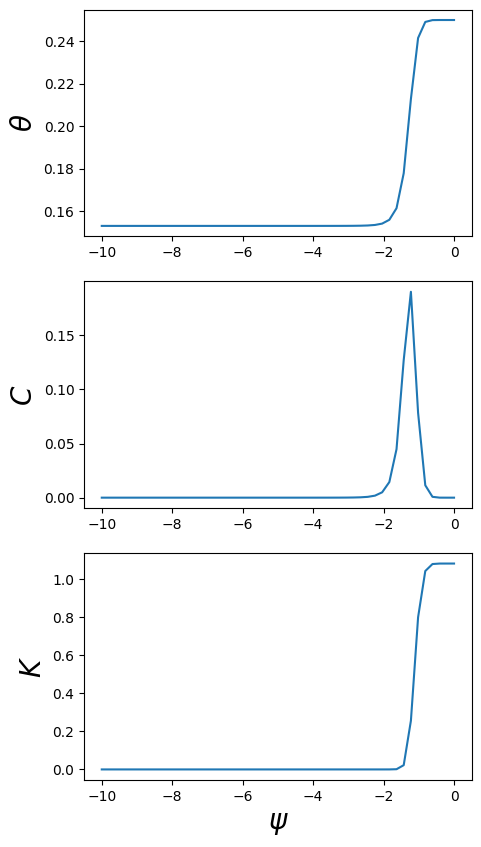

In [10]:
## Calculating theta, C, and K

psi = np.linspace(-10,0)

theta = vg.thetaFun(psi,p) #calculates soil water content
C=vg.CFun(psi,p) # calculates the capillary pressure
K=vg.KFun(psi,p) # calculates the hydraulic conductivity


## Plotting the Results
pl.rcParams['figure.figsize'] = (5.0, 10.0) # Units in inches
pl.subplot(311)
pl.plot(psi,theta)
pl.ylabel(r'$\theta$', fontsize=20)

pl.subplot(312)
pl.plot(psi,C)
pl.ylabel(r'$C$',fontsize=20)

pl.subplot(313)
pl.plot(psi,K)
pl.ylabel(r'$K$', fontsize=20)
pl.xlabel(r'$\psi$', fontsize=20)

In [11]:
# This block of code sets up and runs the model

# Define boundary conditions for top and bottom of the profile
qTop = -0.01  # Infiltration rate at the top boundary (negative for downward flow)
qBot = []  # Empty list means free drainage or no flux at the bottom
psiTop = []  # Empty list means psiTop will be determined by default conditions
psiBot = []  # Empty list means psiBot will be determined by default conditions

## Grid in space
dz = 0.1  # Spatial grid resolution (spacing between nodes in meters)
ProfileDepth = 5  # Total profile depth in meters
z = np.arange(dz / 2.0, ProfileDepth, dz)  # Grid of depths (midpoints between nodes)
n = z.size  # Number of nodes (spatial grid points)

## Grid in time
t = np.linspace(0, 10, 101)  # Time grid from 0 to 10 days with 101 time steps

## Initial conditions
psi0=-z # Initial pressure head distribution: negative value with depth

## Solve
psi=odeint(RichardsModel,psi0,t,args=(dz,n,p,vg,qTop,qBot,psiTop,psiBot),mxstep=5000000);

print("Model simulation completed successfully")

Model run successfully


In [12]:
# Post process model output to get useful information

# Get water content
theta=vg.thetaFun(psi,p)

# Get total profile storage
S=theta.sum(axis=1)*dz

# Get change in storage [dVol]
dS=np.zeros(S.size)
dS[1:]=np.diff(S)/(t[1]-t[0])

# Get infiltration flux
if qTop == []:
    KTop=vg.KFun(np.zeros(1)+psiTop,p)
    qI=-KTop*((psiTop-psi[:,n-1])/dz*2+1)
else:
    qI=np.zeros(t.size)+qTop
    
# Get discharge flux
if qBot == []:
    if psiBot == []:
        # Free drainage
        KBot=vg.KFun(psi[:,0],p)
        qD=-KBot
    else:
        # Type 1 boundary
        KBot=vg.KFun(np.zeros(1)+psiBot,p)
        qD=-KBot*((psi[:,0]-psiBot)/dz*2+1.0)
else:
    qD=np.zeros(t.size)+qBot

Text(0.5, 0, '$\\theta$ [-]')

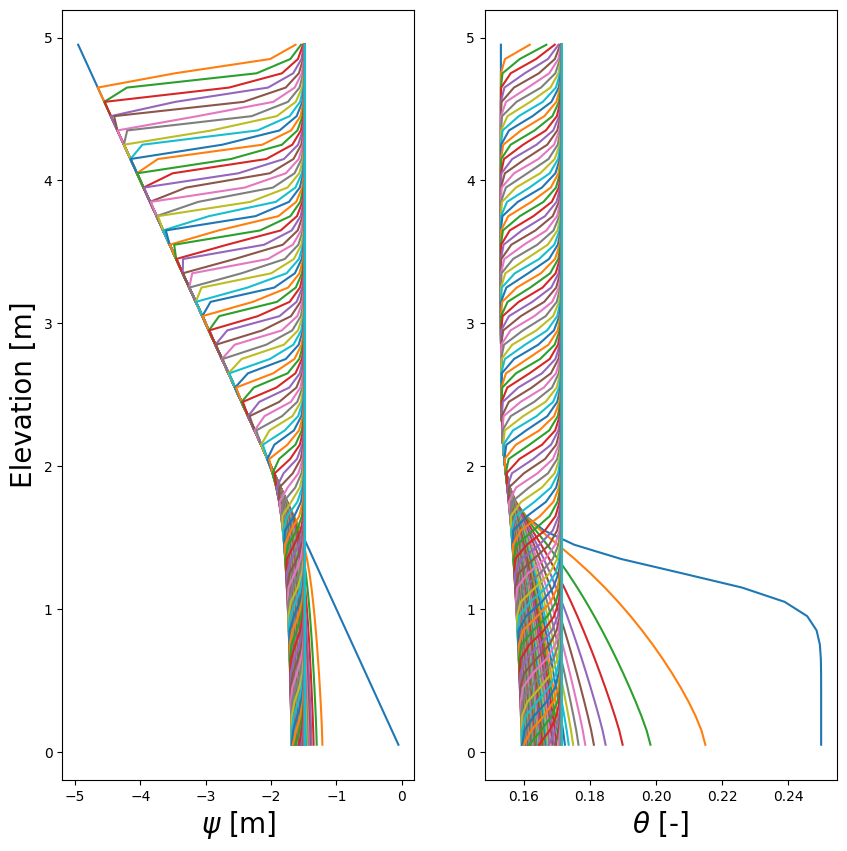

In [13]:
# Plot vertical profiles
pl.rcParams['figure.figsize'] = (10.0, 10.0)
for i in range(0,t.size-1):
    pl.subplot(121)
    pl.plot(psi[i,:],z)
    pl.subplot(122)
    pl.plot(theta[i,:],z)

pl.subplot(121)
pl.ylabel('Elevation [m]',fontsize=20)
pl.xlabel(r'$\psi$ [m]',fontsize=20)
pl.subplot(122)
pl.xlabel(r'$\theta$ [-]',fontsize=20)

(0.0, 0.02)

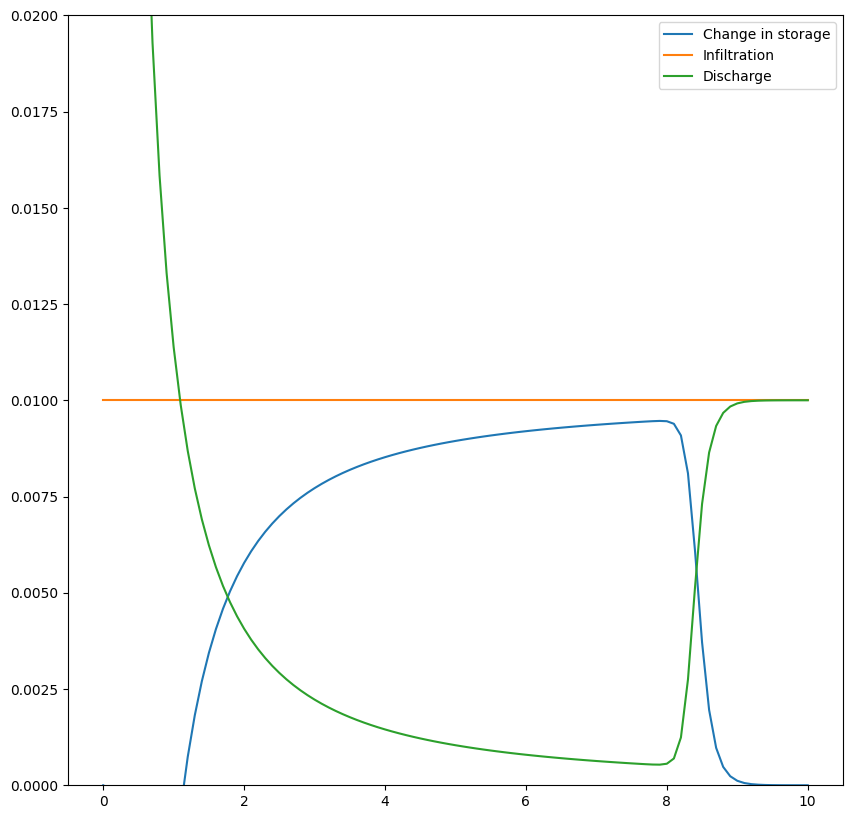

In [18]:
# Plot timeseries
dt = t[2]-t[1]
pl.plot(t,dS,label='Change in storage') # Plot change in storage
pl.plot(t,-qI,label='Infiltration') # Plot infiltration
pl.plot(t,-qD,label='Discharge') # Plot discharge
pl.legend(loc="upper right") # Add labels and legend
pl.ylim((0,0.02)) # Set y-axis limits